# Learning Deep Convolutional Networks for Demosaicing

> Original paper by Nai-Sheng Syu, Yu-SHeng Chen, Yung-Yu Chuang [[1]](https://arxiv.org/pdf/1802.03769.pdf)

> Homepage for the paper: [link](http://www.cmlab.csie.ntu.edu.tw/project/Deep-Demosaic/) (As of 21.4.2019 the authors have not released the original code)

### About the notebook

This notebook and repository aims to reproduce the state-of-the-art results provided in the [1]. 

**Author:** Eemeli Saari

**Email:** saari.eemeli@gmail.com

**Modified:** 21.4.2019

> **NOTE:**

---

In [22]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

We'll set a standard seed for reproducibility.

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Data

We load the data from the authors homepage and define a Pytorch dataset that reads patches from the images.

The image patches are densely extracted $33 \times 33$ patches that are padded with zeros to make up for the missing channels.

In [5]:
from dataset import download_data, ImagePatchDataset

In [6]:
%time dataset = ImagePatchDataset(root=download_data(), sample_size=2)
len(dataset)

CPU times: user 23 ms, sys: 14.5 ms, total: 37.5 ms
Wall time: 41.8 ms


8526

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

## DMCNN Model

We'll first define the DMCNN model described by the paper [1].

Model contains

- Feature extraction layer
  - 128 Filters with $9\times9$ kernels.
- Non-linear mapping layer
  - 64 Filters with $1\times1$ kernels.
- Reconstruction layer
  - 3 Kernels constructing the resulted colored image
  - $5\times5$ kernels.

In [7]:
class DMCNN(torch.nn.Module):
    """DMCNN
    
    Model adopted from [link](https://arxiv.org/pdf/1802.03769.pdf)
    """
    def __init__(self):
        super(DMCNN, self).__init__()
        
        self.feature_layer = torch.nn.Sequential(
            torch.nn.Conv2d(3, 128, kernel_size=9),
            torch.nn.ReLU()
        )
        
        self.mapping_layer = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=1),
            torch.nn.ReLU()
        )
        
        self.reconstruction_layer = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=5),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        out = self.feature_layer(x)
        out = self.mapping_layer(out)
        out = self.reconstruction_layer(out)
        return out


In [8]:
%time model = DMCNN()

CPU times: user 1.66 ms, sys: 2.7 ms, total: 4.36 ms
Wall time: 3.67 ms


In [9]:
summary(model, input_size=(3, 33, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 25, 25]          31,232
              ReLU-2          [-1, 128, 25, 25]               0
            Conv2d-3           [-1, 64, 25, 25]           8,256
              ReLU-4           [-1, 64, 25, 25]               0
            Conv2d-5            [-1, 3, 21, 21]           4,803
              ReLU-6            [-1, 3, 21, 21]               0
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.85
Params size (MB): 0.17
Estimated Total Size (MB): 2.03
----------------------------------------------------------------


In [10]:
model = model.double()

As we can see it's a fairly shallow convolution neural network that should be fairly fast to train.

## Training the model

The Pytorch framework doesn't offer the similar sklearn type API that's supported in the Keras so we'll need to manually create the training loop.

First we'll define the the loss function as the standard $L_2$ norm.

$$ L(\theta) = \frac{1}{n} \sum_{n}^{n=1}||F(Y_i ; \theta) - X_i||^2 $$

In [ ]:
criterion = torch.nn.MSELoss()

According to the original paper the DMCNN is trained using the stochastic gradient descent with learning rate 1 for the first two layers and 0.1 for the last layer.

This comes easy to define in Pytorch as following:

In [ ]:
optimizer = torch.optim.SGD(
    params = [
        {"params": model.feature_layer.parameters(), "lr": 1},
        {"params": model.mapping_layer.parameters(), "lr": 1},
        {"params": model.reconstruction_layer.parameters(), "lr": 0.1}
    ]
)

In [ ]:
n_epochs = 15

We'll define the training loop to include the clipping to keep the gradients within -1 and 1.

In [23]:
total_step = len(data_loader)
loss_list = []
for epoch in range(n_epochs):
    epoch_loss = []
    for idx, (cfa, target) in enumerate(data_loader):
        outputs = model(cfa)
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        epoch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if idx % 10 == 0:
            #print(outputs)
            print(f'Epoch [{epoch}/{n_epochs}], Step [{idx}/{total_step}], Loss: {loss.item()}')
    epoch_stats = np.array(epoch_loss)
    print(f'\nFinished Epoch {epoch}, Loss --- mean: {epoch_stats.mean()}, std {epoch_stats.std()}\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
    ax1.imshow(np.array(outputs[-1].tolist()).reshape((21, 21, 3)))
    ax2.imshow(np.array(cfa[-1].tolist()).reshape((33, 33, 3)))
    ax3.imshow(np.array(target[-1].tolist()).reshape((21, 21, 3)))
    plt.show()

NameError: name 'data_loader' is not defined

In [11]:
def patch_to_tensor(patch):
    shape = list(patch.shape)
    tensor = torch.from_numpy(patch.reshape(tuple(reversed(shape))))
    return tensor

In [13]:
patch_to_tensor(np.zeros((21, 21, 3))).shape

torch.Size([3, 21, 21])

In [ ]:
def demosaic(model, cfa):
    

## DMCNN-VD Model

Model is defined to have 20 identical convolution layers with each 64 Filters with kernel size of 3. Authors of the papers also used the padding of 1.

There was no simple explanation of the residual layer that was used so the one from [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py) was used.

In [24]:
class DMCNN_VD(torch.nn.Module):
    """DMCNN-VD

    Model adopted from [link](https://arxiv.org/pdf/1802.03769.pdf)
    """
    def __init__(self, n_layers=20):
        super(DMCNN_VD, self).__init__()

        self.n_layers = n_layers
        self.layer0 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.SELU()
        )
        for i in range(1, self.n_layers):
            setattr(self, f'layer{i}', self.conv_layer)

        # https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py
        self.residual = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=3, padding=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(3, 3, kernel_size=3, padding=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(3)
        )
        self._msra_init()
            
    def forward(self, x):
        out = getattr(self, 'layer0')(x)
        for i in range(1, self.n_layers):
            out = getattr(self, f'layer{i}')(out)

        out = self.residual(out)
        out += x
            
        return out
    
    @property
    def conv_layer(self):
        return torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.SELU()
        )
    
    @property
    def n_params(self):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    def _msra_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

In [25]:
%time model_vd = DMCNN_VD()

CPU times: user 41.4 ms, sys: 3.26 ms, total: 44.6 ms
Wall time: 43.3 ms


In [26]:
summary(model_vd, input_size=(3, 33, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 33, 33]           1,792
       BatchNorm2d-2           [-1, 64, 33, 33]             128
              SELU-3           [-1, 64, 33, 33]               0
            Conv2d-4           [-1, 64, 33, 33]          36,928
       BatchNorm2d-5           [-1, 64, 33, 33]             128
              SELU-6           [-1, 64, 33, 33]               0
            Conv2d-7           [-1, 64, 33, 33]          36,928
       BatchNorm2d-8           [-1, 64, 33, 33]             128
              SELU-9           [-1, 64, 33, 33]               0
           Conv2d-10           [-1, 64, 33, 33]          36,928
      BatchNorm2d-11           [-1, 64, 33, 33]             128
             SELU-12           [-1, 64, 33, 33]               0
           Conv2d-13           [-1, 64, 33, 33]          36,928
      BatchNorm2d-14           [-1, 64,

In [18]:
707e3 / 44e3

16.068181818181817

DMCNN-VD is roughly 16x larger model than the shallow DMCNN but it's still a tiny compared to some of the standard networks like VGG16 etc.

## Training the model

The DMCNN-VD uses the same $L_2$ norm for training. However the original CFA is summed to the models residual output which we take into account when already defined the model.

For the optimizer Adam is used with lr parameter $1^{-5}$

In [19]:
optimizer_vd = torch.optim.Adam(model_vd.parameters(), lr=1e-5)

In [20]:
n_epochs = 500

For this model we'll choose a much larger epoch number and train the model in a similar manner to DMCNN. However we'll be dropping the clipping as the residual learning is used.

In [21]:
total_step = len(data_loader)
loss_list = []
for epoch in range(n_epochs):
    epoch_loss = []
    for idx, (cfa, target) in enumerate(data_loader):
        outputs = model_vd(cfa)
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        epoch_loss.append(loss.item())

        optimizer_vd.zero_grad()
        loss.backward()
        optimizer_vd.step()

        if idx % 10 == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Step [{idx}/{total_step}], Loss: {loss.item()}')
    epoch_stats = np.array(epoch_loss)
    print(f'\nFinished Epoch {epoch}, Loss --- mean: {epoch_stats.mean()}, std {epoch_stats.std()}\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
    ax1.imshow(np.array(outputs[-1].tolist()).reshape((21, 21, 3)))
    ax2.imshow(np.array(cfa[-1].tolist()).reshape((33, 33, 3)))
    ax3.imshow(np.array(target[-1].tolist()).reshape((21, 21, 3)))
    plt.show()

NameError: name 'data_loader' is not defined

## Evaluation

We'll evaluate the models and compare it to some of the classical methods provided.

In [31]:
from colour_demosaicing import mosaicing_CFA_Bayer

In [28]:
lighthouse = cv2.cvtColor(cv2.imread('data/lighthouse.png'), cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'lighthouse.png')

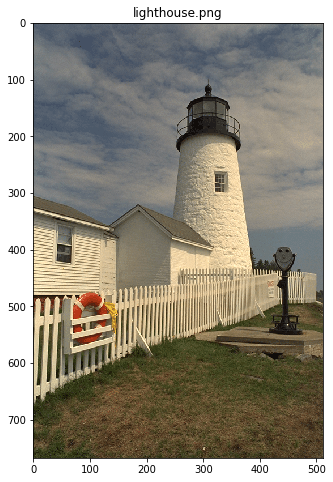

In [37]:
plt.figure(figsize=(10,8))
plt.imshow(lighthouse)
plt.title('lighthouse.png')

In [42]:
eval_patch = mosaicing_CFA_Bayer(lighthouse)[450:550, 300: 400]

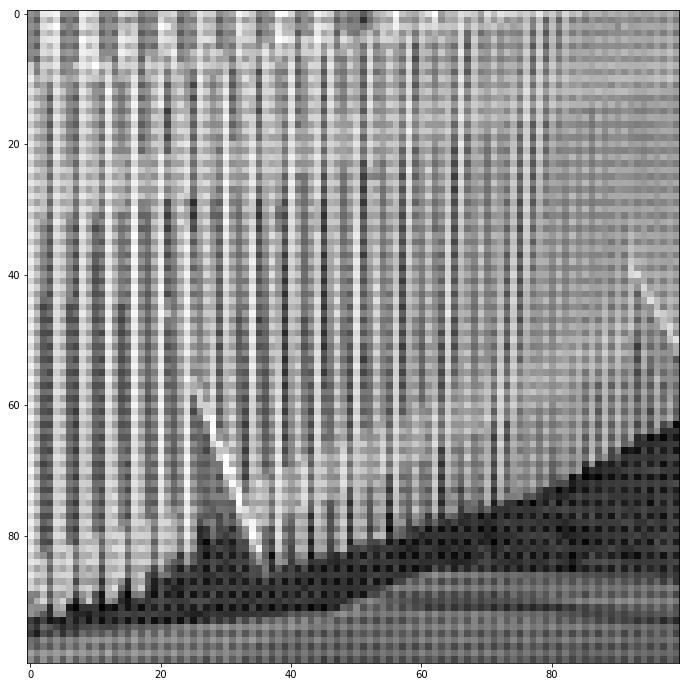

In [43]:
plt.figure(figsize=(15,12))
plt.imshow(eval_patch, cmap='gray')